*** The project objective is to accurately predict the probability of customer churn***

[WSDM KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge)

## The Business Problem

KKBox is the leader in music streaming in Asia and their business model is based on paid user accounts and advertising revenue with the former being a significant contributor. The client (KKBox) wants a predictive model of customer churn built.

Stage 1 requires descriptive analytics. We will present assumptions about the data & the intended model as we preprocess and explore...

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import re
%config Application.log_level="INFO"

In [2]:
# As the name implies, this csv holds subscriber information

members = pd.read_csv('members_v2.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
1,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
2,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,20110918
3,OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=,1,0,NaN,7,20110918
4,4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=,4,28,female,9,20110920


In [3]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795090 entries, 0 to 795089
Data columns (total 6 columns):
msno                      795090 non-null object
city                      795090 non-null int64
bd                        795090 non-null int64
gender                    318249 non-null object
registered_via            795090 non-null int64
registration_init_time    795090 non-null int64
dtypes: int64(4), object(2)
memory usage: 36.4+ MB


**Null values in the "gender" variable.**

In [4]:
members['gender'].describe()

count     318249
unique         2
top         male
freq      168385
Name: gender, dtype: object

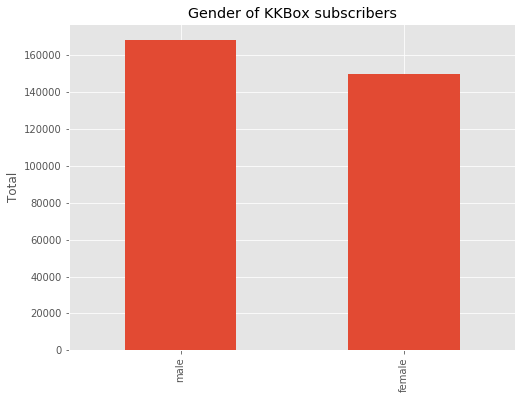

In [5]:
gender = members['gender'].value_counts()
gender.plot(kind='bar',stacked=True, figsize=(8,6))

plt.ylabel('Total')
plt.title("Gender of KKBox subscribers")
plt.show()

In [6]:
# Creating a 'missing' category/level for the gender variable

members['gender'] = members['gender'].fillna('missing')

# Investigating the age variable...

print members['bd'].max()
members['bd'].min()

2016


-3152

**The bd column is a placeholder for subscriber age whose entries range from -3152 to 2016**

*What assumptions can we make about this variable?*

- It is possible this field is stored in a Unix-like database that holds dates as either positive or negative offsets of 1970
- The values could also be user entry errors

As KKBox only accepts registrants from within Asia, we had someone from Hong Kong sign up and send us screenshots of the DOB data entry:

<table><tr><td><img src="data_files/images/correct.jpg" style="width: 250px;"></td><td><img src="data_files/images/wrong1.jpg" style="width: 250px;"></td><td><img src="data_files/images/wrong2.jpg" style="width: 250px;"></td></tr></table>

## Clearly, KKbox has data validation issues they need to attend to...

Our observations clearly rule out the Unix case... 

*** The number of subscribers of age 0 is staggering ***

In [7]:
print float(len(members['bd'][members['bd'] == 0]))*100/len(members['bd']),'% of subscribers in dataset are age 0'

60.4345420015 % of subscribers in dataset are age 0


** We will assume there are no supercentenarians beyond 120 years of age and mark such occurrences as invalid. **

[Link here](https://en.wikipedia.org/wiki/List_of_supercentenarians_from_Asia)

** We will also assume children aged 1 - 10 have been signed up by their parents. We do not expect this assumption to affect our model significantly especially since there are so few of them. **

In [8]:
members.loc[members['bd'] < 0, 'bd'] = np.nan
members.loc[members['bd'] > 120, 'bd'] = np.nan

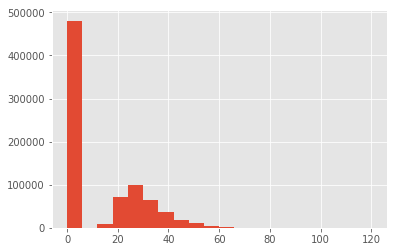

In [9]:
members['bd'].hist(bins=20)
plt.show()

In [10]:
median = members['bd'][members['bd'] > 0].median()
members['bd'] = members['bd'].fillna(median)

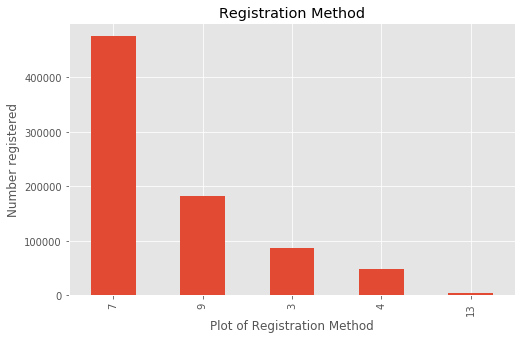

In [11]:
registered_via = members['registered_via'].value_counts()
registered_via.plot(kind='bar',stacked=True, figsize=(8,5))

plt.xlabel('Plot of Registration Method')
plt.ylabel('Number registered')
plt.title("Registration Method")
plt.show()

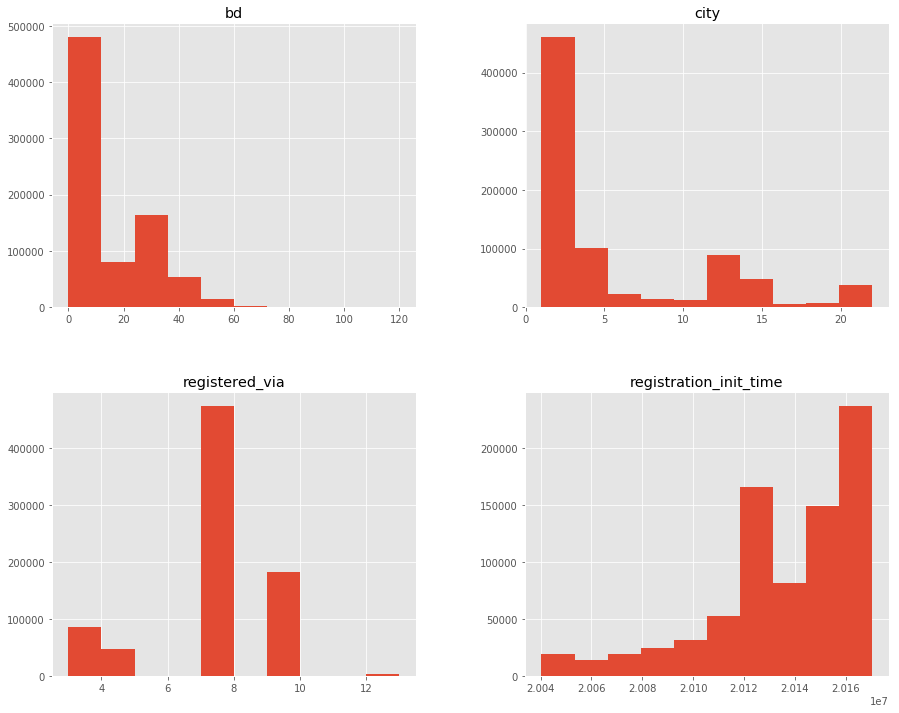

In [12]:
members.hist(figsize=(15,12))
plt.show()

In [13]:
train = pd.read_csv("train_v2.csv")

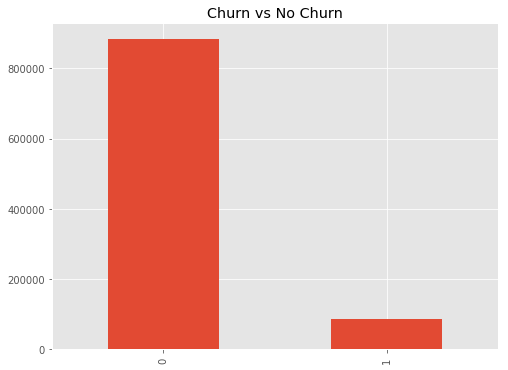

In [14]:
churn = train['is_churn'].value_counts()
churn.plot(kind='bar',stacked=True, figsize=(8,6))

plt.title("Churn vs No Churn")
plt.show()

** We're running our predictive model on data that we've further pre-processed with Alteryx Designer **

Workflow-1: Extracting Member Information for the train IDs

<img src="data_files/images/train_members.jpg">

Workflow-2: Extracting Transactions Information for the train IDs

<img src="data_files/images/train_transactions.jpg">

Workflow-3: Creating new variables from the transactions data

<img src="data_files/images/train_New_Variables.jpg">

Workflow-4: Extracting information on from user logs data using the train IDs

<img src="data_files/images/train_userlogs.jpg">

Workflow-6: Creating new variables from the userlogs & train combined data

<img src="data_files/images/train_userlogs_info.jpg">

The train dataset was created using the above workflows in Alteryx. Similar workflows were created to build the test dataset.

We will run Random Forest Classifier on our combined dataset to identify the most important features and disregard age if it is not an important feature.

In [29]:
trans = pd.read_csv('data_files/transactions_v2.csv')
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [30]:
logs = pd.read_csv('data_files/user_logs_v2.csv')
logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [3]:
data1 = pd.read_csv('data_files/finaltrain_V2.csv')
data2 = pd.read_csv('data_files/finaltest_V2.csv')

In [4]:
print data1.shape
print data2.shape

(970960, 147)
(907471, 141)


#### From investigation, the additional variables in train data not in test data are:
  list_price_105  
  list_price_126  
  list_price_210  
  plan_days_3  
  plan_days_21  
  list_price_1299  
  list_price_1399 
  
 #### The additional variables in test data not in train data are:
 city_21

In [5]:
# completing dataframes so train and test have the same columns

# test dataframe
data2['list_price_105'] = 0
data2['list_price_126'] = 0
data2['list_price_210'] = 0
data2['plan_days_3'] = 0
data2['plan_days_21'] = 0
data2['list_price_1299'] = 0
data2['list_price_1399'] = 0
# train dataframe
data1['city_21'] = 0

In [6]:
print data1.shape
print data2.shape

(970960, 148)
(907471, 148)


In [7]:
# creating a function to snakify column names
def snakify(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# snakifying column names in both train and test
data1.columns = [snakify(col) for col in data1.columns]
data2.columns = [snakify(col) for col in data2.columns]

# creatiung a list of column names that are def. not dummy variables
subset = list(data1.columns[:17])
type(subset)

list

In [9]:
# looking for the columns that hold null values in both train and hold-out dataset
print data1.columns[data1.isnull().any()]
print data2.columns[data2.isnull().any()]

Index([u'sum_num_unq', u'avg_num_unq', u'sum_total_number_songs',
       u'avg_total_number_songs', u'sum_total_secs', u'avg_total_secs',
       u'avg_total_score', u'bd', u'registered_via', u'registration_init_time',
       u'registration_init_days', u'total_amount_paid', u'is_auto_renew'],
      dtype='object')
Index([u'sum_num_unq', u'avg_num_unq', u'sum_total_number_songs',
       u'avg_total_number_songs', u'sum_total_secs', u'avg_total_secs',
       u'avg_total_score', u'bd', u'registered_via', u'registration_init_time',
       u'registration_init_days', u'total_amount_paid', u'is_auto_renew'],
      dtype='object')


In [10]:
# inspecting datatypes in our subset
data1[subset].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 17 columns):
msno                      970960 non-null object
sum_num_unq               754551 non-null float64
avg_num_unq               754551 non-null float64
sum_total_number_songs    754551 non-null float64
avg_total_number_songs    754551 non-null float64
sum_total_secs            754551 non-null float64
avg_total_secs            754551 non-null float64
avg_total_score           754551 non-null float64
bd                        699492 non-null float64
registered_via            699492 non-null float64
registration_init_time    699492 non-null object
registration_init_days    699492 non-null object
no_of_transactions        970960 non-null int64
no_of_cancellations       970960 non-null int64
cancelled                 970960 non-null int64
total_amount_paid         933578 non-null float64
is_auto_renew             933578 non-null float64
dtypes: float64(11), int64(3), object(3)
memory 

In [11]:
# converting the registration date variable from object to float
data1['registration_init_days'] = data1['registration_init_days'].str.replace(" days 00:00:00.000000000","").astype(float)
data2['registration_init_days'] = data2['registration_init_days'].str.replace(" days 00:00:00.000000000","").astype(float)

# subsetting categorical and continuous variables so we can transform with ease
cat = ['registered_via', 'is_auto_renew']
intgr = ['sum_num_unq', 'avg_num_unq', 'sum_total_number_songs', 'avg_total_number_songs', 'sum_total_secs', 'avg_total_secs',
        'avg_total_score', 'bd', 'registration_init_days', 'total_amount_paid']

# how many nulls exist in each of our subsets?
data1[subset].isnull().sum()

msno                           0
sum_num_unq               216409
avg_num_unq               216409
sum_total_number_songs    216409
avg_total_number_songs    216409
sum_total_secs            216409
avg_total_secs            216409
avg_total_score           216409
bd                        271468
registered_via            271468
registration_init_time    271468
registration_init_days    271468
no_of_transactions             0
no_of_cancellations            0
cancelled                      0
total_amount_paid          37382
is_auto_renew              37382
dtype: int64

In [12]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
# from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import Imputer

# we have registration_init_days as a continuous variable so _init_time is excluded
data1 = data1.drop(['registration_init_time'], axis=1)
data2 = data2.drop(['registration_init_time'], axis=1)

# imputing median values to nulls of continuous variables and mode to categoricals
imp_int = Imputer(strategy='median')
imp_cat = Imputer(strategy='most_frequent')

data1[intgr] = imp_int.fit_transform(data1[intgr])
data1[cat] = imp_cat.fit_transform(data1[cat])

data1.head(10)

,msno,sum_num_unq,avg_num_unq,sum_total_number_songs,avg_total_number_songs,sum_total_secs,avg_total_secs,avg_total_score,bd,registered_via,...,city_16,city_17,city_18,city_19,city_20,city_22,is_female,is_male,is_missing,city_21
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,885.0,28.548387,1089.0,35.129032,192527.891052,6210.577131,46.353226,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,468.0,16.714286,567.0,20.250000,115411.258972,4121.830678,35.864643,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,828.0,39.428571,970.0,46.190476,149896.558472,7137.931356,51.978095,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,230.0,7.931034,682.0,23.517241,116433.246857,4014.939547,36.092069,21.0,7.0,...,0,0,1,0,0,0,0,1,0,0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,223.0,10.619048,233.0,11.095238,36636.637947,1744.601807,13.830476,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
5,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,39.0,19.500000,55.0,27.500000,10243.064697,5121.532349,43.285000,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
6,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,115.0,14.375000,157.0,19.625000,28450.267548,3556.283443,28.923750,28.0,7.0,...,0,0,0,0,0,0,0,0,1,0
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,163.0,18.111111,171.0,19.000000,31788.296082,3532.032898,27.855556,28.0,9.0,...,0,0,0,0,0,0,0,0,1,0
8,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,186.0,13.285714,319.0,22.785714,65936.727478,4709.766248,39.546429,28.0,7.0,...,0,0,0,0,0,0,0,0,0,0
9,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,330.0,19.233333,442.0,25.333333,82640.240601,4709.031179,37.877895,25.0,9.0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
corr_matrix = data1.corr()
corr_matrix['is_churn'].sort_values(ascending=False)

is_churn                  1.000000
cancelled                 0.332551
no_of_cancellations       0.324690
total_amount_paid         0.311156
payment_method_32         0.278709
list_price_1788           0.218210
plan_days_410             0.217041
list_price_894            0.175267
plan_days_195             0.175262
plan_days_90              0.171319
plan_days_180             0.161787
list_price_536            0.155623
list_price_0              0.148412
payment_method_17         0.137728
plan_days_240             0.108185
no_of_transactions        0.107935
list_price_477            0.105792
payment_method_38         0.103036
payment_method_20         0.092929
list_price_298            0.087528
plan_days_60              0.083418
list_price_447            0.083200
list_price_1200           0.081645
plan_days_100             0.081245
list_price_480            0.078634
plan_days_120             0.078011
payment_method_15         0.074910
payment_method_22         0.070136
list_price_1599     

In [17]:
corr_matrix['is_churn'].sort_values(ascending=False)[:21]

is_churn               1.000000
cancelled              0.332551
no_of_cancellations    0.324690
total_amount_paid      0.311156
payment_method_32      0.278709
list_price_1788        0.218210
plan_days_410          0.217041
list_price_894         0.175267
plan_days_195          0.175262
plan_days_90           0.171319
plan_days_180          0.161787
list_price_536         0.155623
list_price_0           0.148412
payment_method_17      0.137728
plan_days_240          0.108185
no_of_transactions     0.107935
list_price_477         0.105792
payment_method_38      0.103036
payment_method_20      0.092929
list_price_298         0.087528
plan_days_60           0.083418
Name: is_churn, dtype: float64

In [18]:
corr_matrix['is_churn'].sort_values(ascending=False)[126:]

city_22             -0.032795
payment_method_40   -0.035384
city_4              -0.039834
payment_method_39   -0.041051
payment_method_34   -0.043467
bd                  -0.044682
payment_method_37   -0.045389
list_price_100      -0.046339
city_5              -0.050139
city_13             -0.057010
is_female           -0.078819
is_male             -0.084582
list_price_149      -0.109322
list_price_99       -0.179135
payment_method_41   -0.223732
is_auto_renew       -0.233051
city_1              -0.240266
is_missing          -0.247009
plan_days_30        -0.652821
city_21                   NaN
Name: is_churn, dtype: float64

In [19]:
# imputing nulls in test dataset with measures of centrality from train to ensure our final predictions will be accurate
data2[intgr] = imp_int.transform(data2[intgr])
data2[cat] = imp_cat.transform(data2[cat])

# Investigating the distribution of churn levels
data1['is_churn'].value_counts()

0    883630
1     87330
Name: is_churn, dtype: int64

In [20]:
data1 = pd.get_dummies(data1, columns=['registered_via'], drop_first=True)
data2 = pd.get_dummies(data2, columns=['registered_via'], drop_first=True)

In [21]:
data1.shape

(970960, 150)

In [143]:
data2.shape

(907471, 150)

In [92]:
intgr

['sum_num_unq',
 'avg_num_unq',
 'sum_total_number_songs',
 'avg_total_number_songs',
 'sum_total_secs',
 'avg_total_secs',
 'avg_total_score',
 'bd',
 'registration_init_days',
 'total_amount_paid']

In [ ]:
for i, col in enumerate(data1.columns[1:]):
    fig = plt.figure(i, figsize=(12,8))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    
    sns.boxplot(data1[col], orient='v', ax=ax2)
    plt.xlabel(col)
    
    

In [35]:
# In hindsight, this would have been a good time to check for multicollinearity
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [150]:
len(data1['msno'].unique())

970960

In [151]:
corr_matrix['avg_total_score'].sort_values(ascending=False)[:21]

avg_total_score           1.000000
avg_total_secs            0.986426
avg_total_number_songs    0.963219
sum_total_secs            0.907292
sum_total_number_songs    0.882840
avg_num_unq               0.809488
sum_num_unq               0.765230
list_price_149            0.096001
list_price_150            0.081925
payment_method_28         0.079066
is_male                   0.074654
is_female                 0.071547
payment_method_39         0.055007
payment_method_38         0.054420
city_13                   0.053259
payment_method_40         0.050570
total_amount_paid         0.048252
payment_method_37         0.046438
list_price_180            0.039836
city_4                    0.038933
city_22                   0.031687
Name: avg_total_score, dtype: float64

In [32]:
data_lr = data1.drop(['is_missing','city_19', 'list_price_143', 'plan_days_14', 'payment_method_10'], axis=1)

In [33]:
data_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Columns: 145 entries, msno to registered_via_13.0
dtypes: float64(11), int64(129), object(1), uint8(4)
memory usage: 1.0+ GB


In [53]:
to_scale = data_lr.columns[1:14].tolist()
to_scale.remove('cancelled')
to_scale

['sum_num_unq',
 'avg_num_unq',
 'sum_total_number_songs',
 'avg_total_number_songs',
 'sum_total_secs',
 'avg_total_secs',
 'avg_total_score',
 'bd',
 'registration_init_days',
 'no_of_transactions',
 'no_of_cancellations',
 'total_amount_paid']

In [54]:
#scaling numeric variables in dataframe while handling outliers
scaler = RobustScaler()
data_lr[to_scale] = scaler.fit_transform(data_lr[to_scale])

In [111]:
matrix['bd'].sort_values(ascending=False)[:21]

bd                    1.000000
registered_via_9.0    0.239464
payment_method_34     0.175254
is_female             0.142722
is_auto_renew         0.140423
city_5                0.136371
payment_method_40     0.126611
is_male               0.117033
list_price_149        0.106764
city_13               0.100161
payment_method_33     0.098731
payment_method_31     0.085609
payment_method_37     0.059093
city_14               0.044912
city_15               0.043506
payment_method_14     0.043445
city_4                0.041942
city_22               0.039560
plan_days_30          0.034714
payment_method_23     0.027261
city_6                0.024024
Name: bd, dtype: float64

In [114]:
l = [1,2,3]

In [130]:
bd_corr = [(label,val) for label,val in zip(matrix['bd'].index, matrix['bd'])]

In [131]:
bd_corr = sorted(bd_corr, key=lambda x: np.abs(x[1]), reverse = True)

In [132]:
bd_corr

[('bd', 1.0),
 ('registration_init_days', -0.28472005672578027),
 ('payment_method_34', 0.17525389631212854),
 ('is_female', 0.14272158612437846),
 ('payment_method_38', -0.1416440149477422),
 ('is_auto_renew', 0.140422860005049),
 ('city_5', 0.13637145784858482),
 ('payment_method_40', 0.12661089465828451),
 ('list_price_149', 0.10676421620545898),
 ('payment_method_33', 0.09873137514324494),
 ('payment_method_31', 0.085608869974911544),
 ('payment_method_41', -0.084982194692770033),
 ('list_price_99', -0.066375292757546375),
 ('payment_method_37', 0.059092683748159645),
 ('payment_method_14', 0.04344527232817063),
 ('sum_num_unq', -0.038233300154512026),
 ('payment_method_29', -0.037291211626687221),
 ('plan_days_30', 0.034713893195895802),
 ('payment_method_39', -0.033517196142386858),
 ('list_price_180', -0.028228387217940337),
 ('list_price_100', -0.025394762317984348),
 ('sum_total_number_songs', -0.024923329833096759),
 ('payment_method_30', -0.024659202068199701),
 ('avg_num_un

In [112]:
matrix['bd'].sort_values(ascending=False)[126:]

list_price_150           -0.020223
avg_num_unq              -0.020863
payment_method_30        -0.024659
sum_total_number_songs   -0.024923
list_price_100           -0.025395
list_price_180           -0.028228
payment_method_39        -0.033517
payment_method_29        -0.037291
sum_num_unq              -0.038233
is_churn                 -0.044682
registered_via_4.0       -0.053711
list_price_99            -0.066375
payment_method_41        -0.084982
city_1                   -0.110647
payment_method_38        -0.141644
registered_via_7.0       -0.142301
registration_init_days   -0.284720
city_21                        NaN
Name: bd, dtype: float64

In [55]:
matrix = data_lr.corr()
matrix['is_churn'].sort_values(ascending=False)[:21]

is_churn               1.000000
cancelled              0.332551
no_of_cancellations    0.324690
total_amount_paid      0.311156
payment_method_32      0.278709
list_price_1788        0.218210
plan_days_410          0.217041
list_price_894         0.175267
plan_days_195          0.175262
plan_days_90           0.171319
plan_days_180          0.161787
list_price_536         0.155623
list_price_0           0.148412
payment_method_17      0.137728
plan_days_240          0.108185
no_of_transactions     0.107935
list_price_477         0.105792
payment_method_38      0.103036
registered_via_7.0     0.101891
payment_method_20      0.092929
list_price_298         0.087528
Name: is_churn, dtype: float64

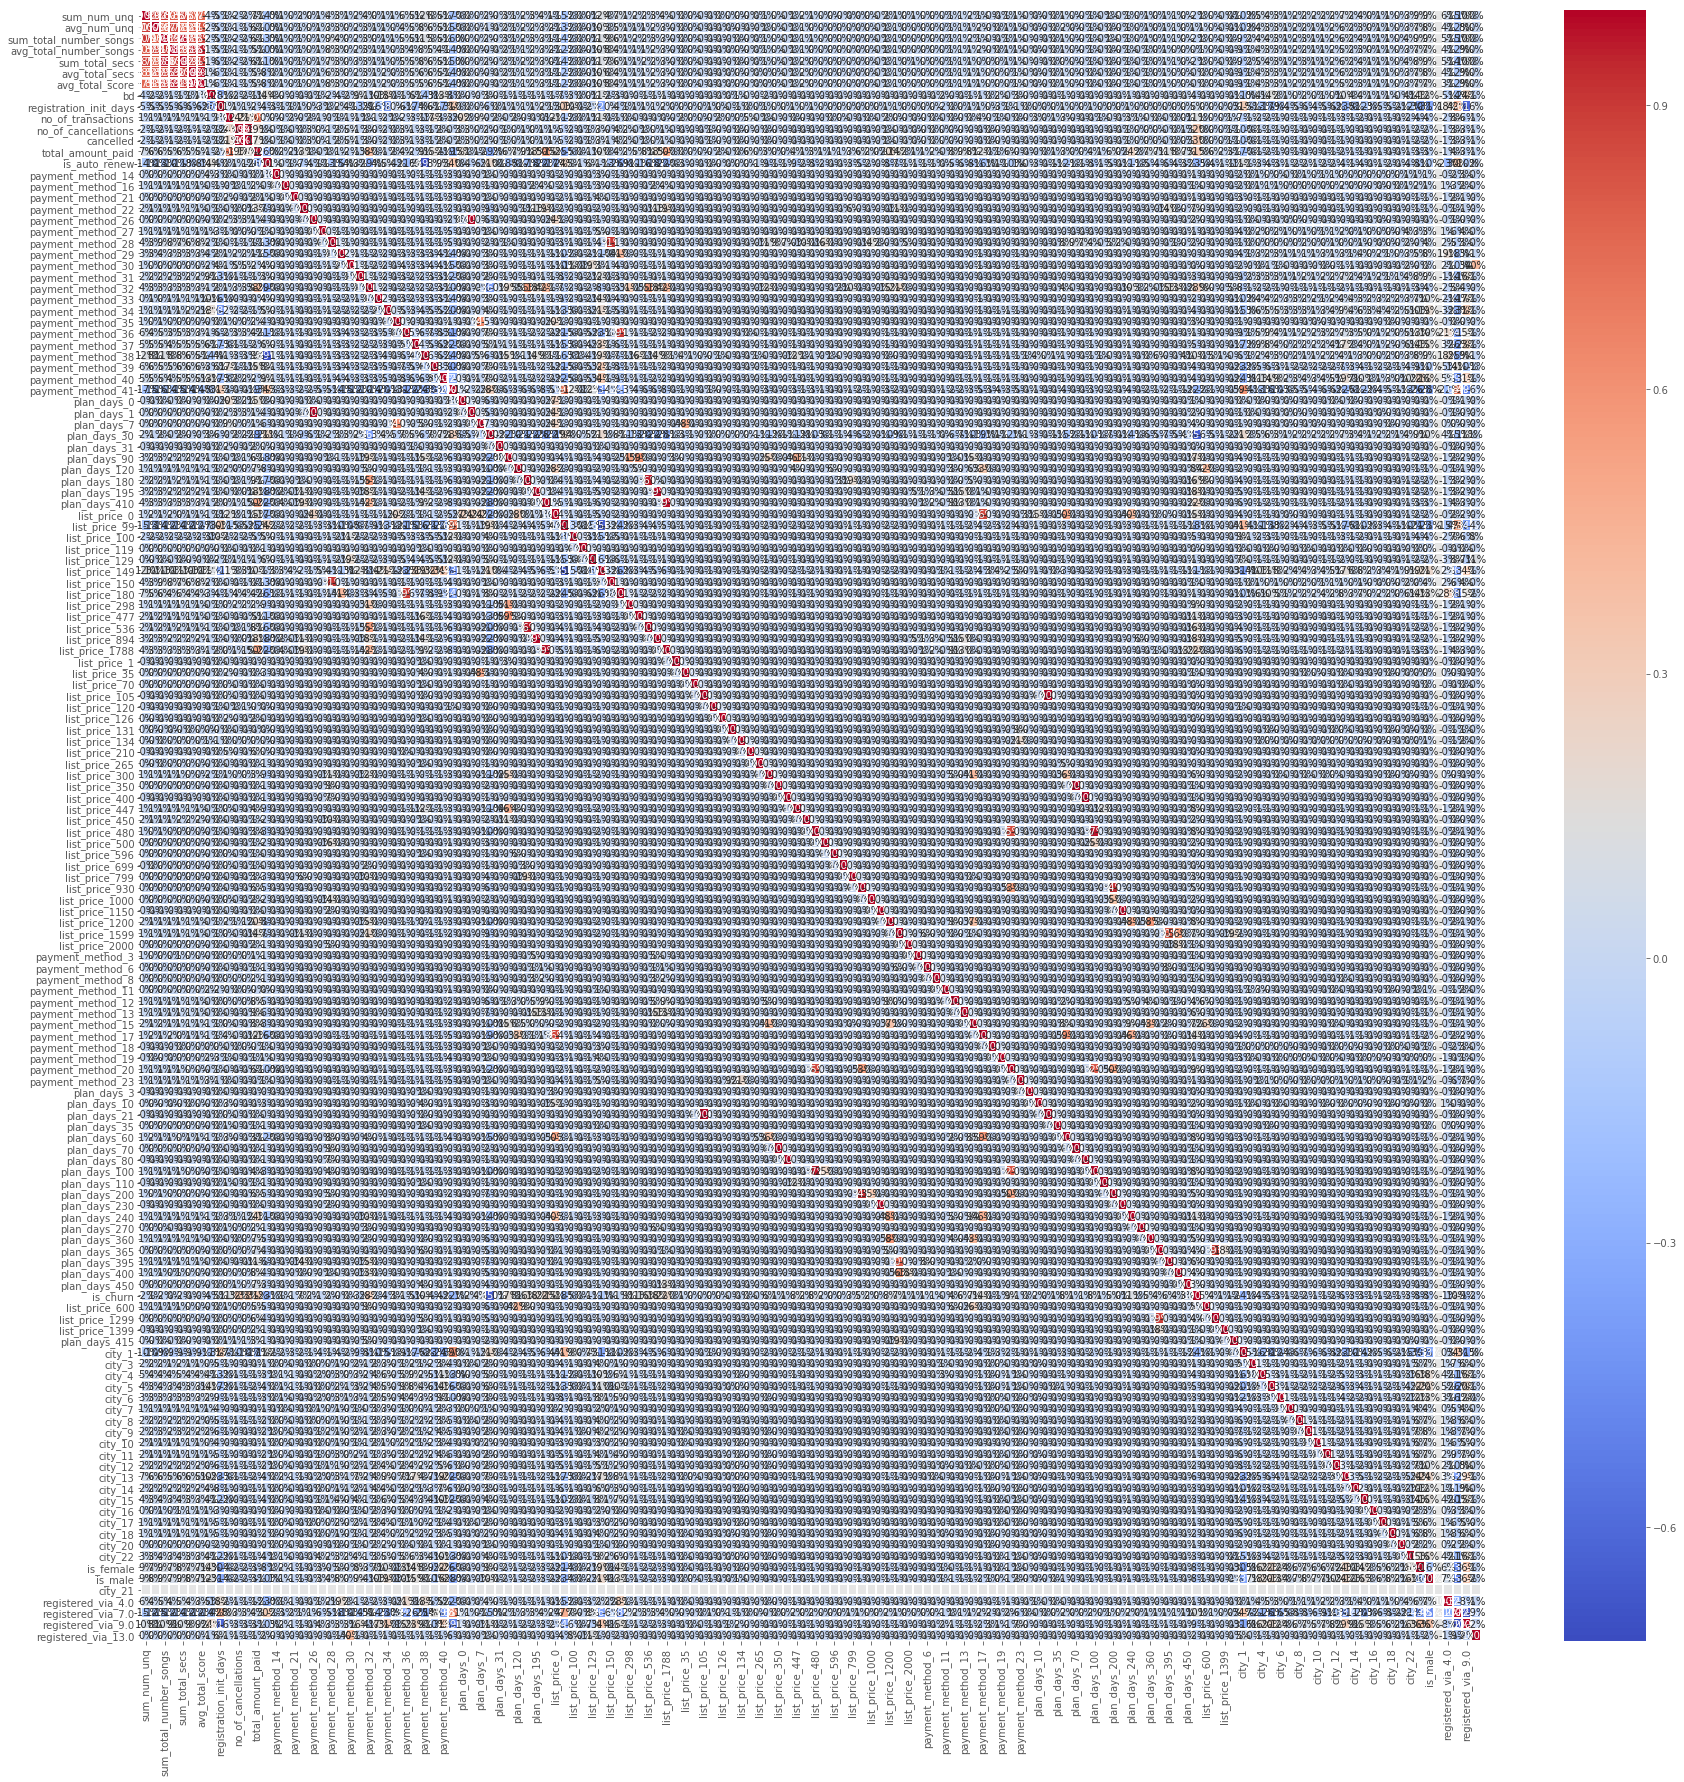

In [58]:
import seaborn as sns

f, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(matrix, cmap="coolwarm", fmt='.0%', linecolor='white',linewidths=1, annot=True)

In [67]:
# removing clearly correlated features
to_drop = ['sum_num_unq','avg_num_unq','sum_total_number_songs','avg_total_number_songs','sum_total_secs','avg_total_secs']
data_lr = data_lr.drop(to_drop, axis=1)

In [73]:
X_lg, y_lg = data_lr.drop(['msno', 'is_churn'], axis=1), data_lr['is_churn']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=13)
for train_index, test_index in sss.split(X_lg, y_lg):
    X_lg_train, y_lg_train = X_lg.loc[train_index], y_lg[train_index]
    X_lg_test, y_lg_test = X_lg.loc[test_index], y_lg[test_index]

In [75]:
lr_grid = [{'C':[1.0, 0.5, 0.05],'penalty':['l1','l2']}]

log_reg = LogisticRegression(max_iter=500, solver='saga', random_state=13)
lr_gridsearch_1 = GridSearchCV(log_reg, lr_grid, cv=8, scoring='recall', return_train_score='warn')
lr_gridsearch_1.fit(X_lg_train, y_lg_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=13, solver='saga', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [1.0, 0.5, 0.05]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [76]:
lr_best = lr_gridsearch_1.best_estimator_
lr_best

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=13, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
y_scores = lr_best.decision_function(X_lg_test)
y_scores

array([ 1.30748128, -2.86398935, -6.23941331, ..., -2.22974208,
        1.31599369, -2.3792002 ])

In [97]:
y_scores.shape

(194192L,)

In [98]:
len(X_lg_test)

194192

In [110]:
lr_gridsearch_1.best_params_, lr_gridsearch_1.best_score_

({'C': 0.05, 'penalty': 'l1'}, 0.73225123096301392)

In [77]:
lr_gridsearch_1.cv_results_

{'mean_fit_time': array([ 1288.60337496,  1051.29999992,  1295.11687502,  1105.13900003,
         1332.26900005,   983.59462497]),
 'mean_score_time': array([ 0.15912503,  0.15912503,  0.17137498,  0.17437497,  0.17612496,
         0.14087501]),
 'mean_test_score': array([ 0.73143536,  0.73205084,  0.73143536,  0.73206516,  0.73225123,
         0.73219398]),
 'mean_train_score': array([ 0.73144354,  0.73213877,  0.73144354,  0.73213263,  0.73224305,
         0.73232484]),
 'param_C': masked_array(data = [1.0 1.0 0.5 0.5 0.05 0.05],
              mask = [False False False False False False],
        fill_value = ?),
 'param_penalty': masked_array(data = ['l1' 'l2' 'l1' 'l2' 'l1' 'l2'],
              mask = [False False False False False False],
        fill_value = ?),
 'params': [{'C': 1.0, 'penalty': 'l1'},
  {'C': 1.0, 'penalty': 'l2'},
  {'C': 0.5, 'penalty': 'l1'},
  {'C': 0.5, 'penalty': 'l2'},
  {'C': 0.05, 'penalty': 'l1'},
  {'C': 0.05, 'penalty': 'l2'}],
 'rank_test_score': ar

In [82]:
y_pred = lr_best.predict(X_lg_test)
y_lg_proba = lr_best.predict_proba(X_lg_test)

#inspecting misclassifications
confusion_matrix(y_lg_test, y_pred)

array([[174011,   2715],
       [  4753,  12713]], dtype=int64)

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_lg_test, y_pred, target_names=['no_churn', 'churn']))

             precision    recall  f1-score   support

   no_churn       0.97      0.98      0.98    176726
      churn       0.82      0.73      0.77     17466

avg / total       0.96      0.96      0.96    194192



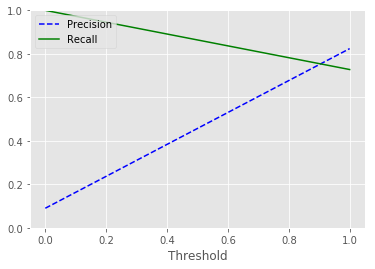

In [86]:
precision_lg, recall_lg, thresh_lg = precision_recall_curve(y_lg_test, y_pred)

# define function to plot precision-recall
def plot_prec_rec_vs_thresh(prec, recall, thresh):
    plt.plot(thresh, prec[:-1], "b--", label='Precision')
    plt.plot(thresh, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_prec_rec_vs_thresh(precision_lg, recall_lg, thresh_lg)
plt.show()

In [106]:
sum(pd.isnull(y_pred))

0

In [88]:
thresh_lg

array([0, 1], dtype=int64)

In [89]:
recall_lg

array([ 1.        ,  0.72787129,  0.        ])

In [90]:
precision_lg

array([ 0.08994191,  0.82402126,  1.        ])

In [87]:
roc_auc_score(y_lg_test, y_pred)

0.85625426391962556

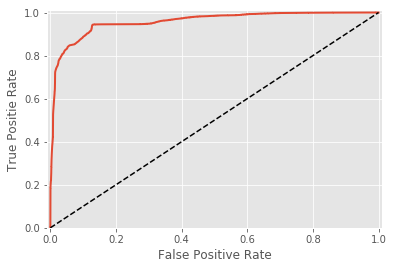

In [134]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(y_lg_test, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.ylim([0,1.01])
    plt.xlim([-0.01,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positie Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [107]:
accuracy_score(y_lg_test, y_pred)

0.96154321496251138

In [109]:
y_train_pred = lr_best.predict(X_lg_train)
accuracy_score(y_lg_train, y_train_pred)

0.96171572464365163

In [135]:
f1_score(y_lg_test, y_pred)

0.77296771447680424

**3.8% misclassified**

***Creating late submission from Log Reg Classifier***

In [138]:
data_lr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Columns: 139 entries, msno to registered_via_13.0
dtypes: float64(7), int64(127), object(1), uint8(4)
memory usage: 1003.8+ MB


In [137]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Columns: 150 entries, msno to registered_via_13.0
dtypes: float64(11), int64(134), object(1), uint8(4)
memory usage: 1014.3+ MB


In [145]:
data2[to_scale] = scaler.fit_transform(data2[to_scale])

In [146]:
late_submit = data2[data_lr.columns]
late_submit.head()

,msno,avg_total_score,bd,registration_init_days,no_of_transactions,no_of_cancellations,cancelled,total_amount_paid,is_auto_renew,payment_method_14,...,city_18,city_20,city_22,is_female,is_male,city_21,registered_via_4.0,registered_via_7.0,registered_via_9.0,registered_via_13.0
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.333285,0.0,-0.096189,0.0,0.0,0,-1.0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.554477,0.0,0.004537,0.0,0.0,0,0.0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,-0.070226,-7.0,0.490018,0.0,0.0,0,0.0,1.0,0,...,1,0,0,0,1,0,0,1,0,0
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,-0.352113,0.0,0.494555,0.0,0.0,0,0.0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,-0.394119,0.0,0.289474,0.0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0


In [147]:
late_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907471 entries, 0 to 907470
Columns: 139 entries, msno to registered_via_13.0
dtypes: float64(7), int64(127), object(1), uint8(4)
memory usage: 938.1+ MB


In [149]:
late_submit_df = late_submit.drop(['msno', 'is_churn'], axis=1)
late_submit_proba = lr_best.predict_proba(late_submit_df)

# appending the probabilities to the test dataframe
l_sub = late_submit[['msno', 'bd']]
l_sub['is_churn'] = late_submit_proba[:, 1]
l_sub = l_sub.drop(['bd'], axis=1)
l_sub.to_csv('late_sub_lg.csv', index=False)
l_sub.head()

C:\Users\Laolu\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.002269
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.005043
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.010012
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.005129
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.058147


In [152]:
l_sub.head(20)

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.002269
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.005043
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.010012
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.005129
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.058147
5,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0.014289
6,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,0.041096
7,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,0.002175
8,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,0.002172
9,++1Wu2wKBA60W9F9sMh15RXmh1wN1fjoVGzNqvw/Gro=,0.041096


## Random Forest Classifier Model

In [25]:
X_rf, y_rf = data1.drop(['is_churn', 'msno'], axis=1), data1['is_churn']

# ensuring we create an even split of the dependent variable (churn)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=13)
for train_index, test_index in sss.split(X_rf, y_rf):
    X_train, y_train = X_rf.loc[train_index], y_rf.loc[train_index]
    # reserving some train data to test our random forest best estimator prior to feeding new data
    X_test, y_test = X_rf.loc[test_index], y_rf.loc[test_index]

In [30]:
# searching an empirically selected grid of trees
rfgrid_test = [{'n_estimators':range(10,35,5)}]

rf_test = RandomForestClassifier(warm_start=True, criterion='gini',random_state=13)
gridsearch_test = GridSearchCV(rf_test, rfgrid_test, cv=8)
gridsearch_test.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100, 150, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
gridsearch_test.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True)

In [26]:
# refining the grid search to make intended model more accurate.
rf_grid = [{'n_estimators':range(150,210,10)}]

rf = RandomForestClassifier(warm_start=True, random_state=13, criterion='gini')
gridsearchRF = GridSearchCV(rf, rf_grid, cv=8)
gridsearchRF.fit(X_train, y_train)

GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [150, 160, 170, 180, 190, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
# Printing parameters of the best estimator
gridsearchRF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=True)

** From the grid search results, using 170 trees in the forest provide the best results **

In [28]:
# assigning best estimator to a variable
rf_best = gridsearchRF.best_estimator_

# viewing feature importance
for score, feature in sorted(zip(rf_best.feature_importances_,X.columns),reverse=True):
    print(score, feature)

(0.21201307356463309, 'plan_days_30')
(0.1017504633168784, 'total_amount_paid')
(0.062750544981417064, 'no_of_cancellations')
(0.054171016967136956, 'cancelled')
(0.044791957406747504, 'registration_init_days')
(0.039009141171181982, 'no_of_transactions')
(0.037048966916647483, 'sum_total_secs')
(0.035267160996703711, 'sum_total_number_songs')
(0.035092319087819408, 'sum_num_unq')
(0.033623101546791302, 'avg_total_secs')
(0.033514116315666947, 'avg_total_score')
(0.03211807278340667, 'avg_total_number_songs')
(0.031732298961323346, 'avg_num_unq')
(0.028808586113599134, 'list_price_149')
(0.02189960787400486, 'is_missing')
(0.018831701650981365, 'payment_method_41')
(0.015628560788538554, 'payment_method_32')
(0.015346516482952318, 'is_auto_renew')
(0.014914842879580477, 'city_1')
(0.014826935038650553, 'bd')
(0.010229300060555179, 'registered_via')
(0.0096654940828607549, 'list_price_99')
(0.009159725890522363, 'payment_method_39')
(0.0080954308942614746, 'is_female')
(0.00775534111072

In [29]:
# extracting the prediction probabilities
y_rf = rf_best.predict(X_test)
y_rfproba = rf_best.predict_proba(X_test)

# inspecting for misclassifications
confusion_matrix(y_test, y_rf)

array([[174854,   1872],
       [  3451,  14015]], dtype=int64)

**2.74% misclassified.**

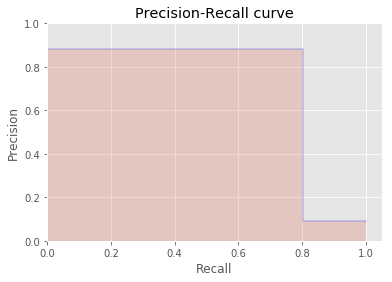

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, y_rf)

plt.step(recall, precision, alpha=0.2, where='post', color='b')
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.05])
plt.title('Precision-Recall curve')

**We can at least confirm we have avoided overfitting**

In [31]:
f1_score(y_test, y_rf)

0.84040416154468855

In [32]:
# running our estimator on new data
X_new = data2.drop(['is_churn', 'msno'], axis=1)
y_proba = rf_best.predict_proba(X_new)

# appending the probabilities to the test dataframe
rf_ans = data2[['msno', 'bd']]
rf_ans['is_churn'] = y_proba[:, 1]
rf_ans = rf_ans.drop(['bd'], axis=1)

C:\Users\Laolu\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
# the submission contains the probabilities of churn as opposed to whether churn or no churn
rf_ans.head(20)

,msno,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.011765
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.017647
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.005882
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.052941
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.182353
5,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0.002914
6,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,0.000082
7,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,0.047059
8,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,0.023529
9,++1Wu2wKBA60W9F9sMh15RXmh1wN1fjoVGzNqvw/Gro=,0.000082


In [34]:
rf_ans.to_csv('submission2_v2.csv', index=False)

** This submission puts us at 145th out of 350 with a logloss of 0.15552. **